In [2]:
from typing import Union, Tuple, List, Optional
from diffusers import DDPMPipeline
from PIL import Image

import math
import os

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid
    
def randn_tensor(
    shape: Union[Tuple, List],
    generator: Optional[Union[List["torch.Generator"], "torch.Generator"]] = None,
    device: Optional["torch.device"] = None,
    dtype: Optional["torch.dtype"] = None,
    layout: Optional["torch.layout"] = None,
):
    """A helper function to create random tensors on the desired `device` with the desired `dtype`. When
    passing a list of generators, you can seed each batch size individually. If CPU generators are passed, the tensor
    is always created on the CPU.
    """
    # device on which tensor is created defaults to device
    rand_device = device
    batch_size = shape[0]

    layout = layout or torch.strided
    device = device or torch.device("cpu")

    if generator is not None:
        gen_device_type = generator.device.type if not isinstance(generator, list) else generator[0].device.type
        if gen_device_type != device.type and gen_device_type == "cpu":
            rand_device = "cpu"

    # make sure generator list of length 1 is treated like a non-list
    if isinstance(generator, list) and len(generator) == 1:
        generator = generator[0]

    if isinstance(generator, list):
        shape = (1,) + shape[1:]
        latents = [
            torch.randn(shape, generator=generator[i], device=rand_device, dtype=dtype, layout=layout)
            for i in range(batch_size)
        ]
        latents = torch.cat(latents, dim=0).to(device)
    else:
        latents = torch.randn(shape, generator=generator, device=rand_device, dtype=dtype, layout=layout).to(device)

    return latents

In [16]:
import torch
import numpy as np
from diffusers import DDPMPipeline, DDIMPipeline, PNDMPipeline
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 9
generator=torch.manual_seed(42)

image_shape = (batch_size, 3, 128, 128)
noise = randn_tensor(image_shape, generator=generator, device=device)

for path in tqdm([x for x in os.listdir('.') if '128' in x]):
    pipeline_type = path.split('-')[-1]
    print(path)

    if pipeline_type == 'ddpm':
        noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
        pipeline = DDPMPipeline.from_pretrained(path).to(device)
    elif pipeline_type == 'ddim':
        noise_scheduler = DDIMScheduler(num_train_timesteps=1000)
        pipeline = DDIMPipeline.from_pretrained(path).to(device)
        noise_scheduler.set_timesteps(1000, device)
    elif pipeline_type == 'pndm':
        noise_scheduler == PNDMScheduler(num_train_timesteps=1000)
        pipeline = PNDMPipeline.from_pretrained(path).to(device)
        noise_scheduler.timesteps = torch.from_numpy(
            np.arange(0, 1000)[::-1].copy()
        )  # it was not implemented correctly in HF, so need to add it manually
        noise_scheduler.set_timesteps(1000, device)
    else:
        print('wrong type')
        break
    
    sample = noise.to(device)
    model = pipeline.unet
    
    test_dir = os.path.join(path, "samples_for_animation")
    
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)
    
    for i, t in tqdm(enumerate(noise_scheduler.timesteps)):
    
        with torch.no_grad():
            residual = model(sample, t).sample
    
        sample = noise_scheduler.step(residual, t, sample).prev_sample
    
        image = (sample / 2 + 0.5).clamp(0, 1)
        image = image.cpu().permute(0, 2, 3, 1).numpy()
        image = pipeline.numpy_to_pil(image)
        grid = make_grid(image, 3, 3)
        grid.save(f"{test_dir}/{t}.png")

  0%|          | 0/9 [00:00<?, ?it/s]

hg-im-size-128-epochs-5-ddpm


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

hg-im-size-128-epochs-10-ddpm


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

hg-im-size-128-epochs-50-ddim


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

hg-im-size-128-epochs-10-ddim


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

hg-im-size-128-epochs-5-ddim


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

hg-im-size-128-epochs-50-ddpm


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

hg-im-size-128-epochs-50-pndm


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

hg-im-size-128-epochs-10-pndm


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

hg-im-size-128-epochs-5-pndm


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

0it [00:00, ?it/s]

### GIFs

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

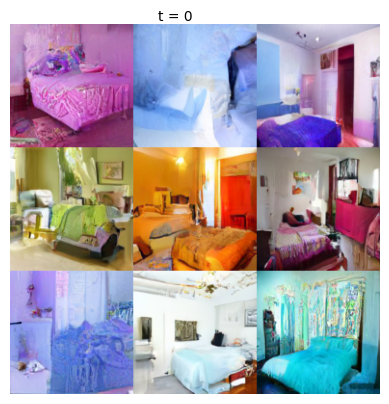

In [24]:
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from PIL import Image
from IPython.display import HTML
from tqdm.auto import tqdm
from pathlib import Path

for path in tqdm([x for x in os.listdir('.') if '128' in x]):

    experiment_folder = Path(path)
    image_folder = experiment_folder / 'samples_for_animation'

    file_names = sorted((fn for fn in os.listdir(image_folder) if fn.endswith('.png')), key=lambda x: - int(x.split('.')[0].split('_')[-1]))
    filtered_file_names = [file_names[i] for i in range(len(file_names)) if i % 10 == 9]

    images = [(file_name.split('.')[0], Image.open(os.path.join(image_folder, file_name))) for file_name in filtered_file_names]

    gif_fps = 10
    
    plt.close('all')
    fig, ax = plt.subplots()
    ax.set_axis_off()
    
    imgs = []
    
    for t, img in tqdm(images):
        ax_img = ax.imshow(img, animated=True)
        title = ax.text(342 // 2, -5, f"t = {t}", ha='center', animated=True)
        imgs.append([ax_img, title])
    
    animate = animation.ArtistAnimation(fig, imgs, interval=1000 // gif_fps, blit=True, repeat_delay=1000)
    animate.save(experiment_folder/ f'{experiment_folder}.gif', writer=animation.PillowWriter(fps=gif_fps))